In [1]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
import cv2             # working with, mainly resizing, images
from tqdm import tqdm
from lxml import etree
import xml.etree.ElementTree as ET
import random
import os                  # dealing with directories
import numpy as np
import numpy.ma as ma
import tensorflow as tf

from keras import backend as K
from keras.layers import Conv2D, Add, ZeroPadding2D, UpSampling2D, Concatenate, MaxPooling2D, Input, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.regularizers import l2
from keras import models
from keras import layers
from keras.layers import Input

#TO DO
#multiple outputs
#code for speed testing
#code for accuracy, pull out categories of unregonized ac plot x-y_cen, plot bb sizes, get IoU, mAP
#visualize filters


Using TensorFlow backend.


In [2]:
TRAIN_annot_dir = 'D:/cnntry/air_data/annot_train'
img_folder = 'D:/cnntry/air_data/trainairplane'

save_path='D:/cnntry'
DATA_file= 'train_airdata.npy' 
num_anchors= 3

input_shape = (416,416)
h, w = input_shape



In [3]:
def read_xml(img_name):
    annot_label = img_name.split('.')[0]+'.xml'           #xml file name
    annot_xml = os.path.join(TRAIN_annot_dir,annot_label)  #xml file full path
    root = etree.parse(annot_xml).getroot()
    #for child in root: print(child.tag, child.attrib)        
    img_w= int(root[3][0].text)
    img_h= int(root[3][1].text)
    bb=[]                                   #list for bounding boxes
    for plane in root.iter("object"):
        for l in range(4): bb.append(int(plane[4][l].text)) 
    return img_w, img_h, bb

def rescale_bb(img_w, img_h, bb, ref=(416,416)):
    w_ratio= ref[0] / img_w
    h_ratio= ref[1] / img_h
    for i in range(0,len(bb),2):
        bb[i]= int(bb[i]* w_ratio)
        bb[i+1]= int(bb[i+1]* h_ratio)
    return bb

def conv_bb_coord(bb):
    for i in range(0,len(bb),4):
        x_cen= int( (bb[i]+ bb[i+2])/2)
        y_cen= int( (bb[i+1]+ bb[i+3])/2)
        w= bb[i+2]- bb[i]
        h= bb[i+3]- bb[i+1]
        bb[i],bb[i+1],bb[i+2],bb[i+3]= x_cen, y_cen, w, h
    return bb


def create_truth_arr(bb, output_shape=(13,13,5), ref=(416,416)):    #bb[x_cen, y_cen, w, h, x_cen, y_cen, w, h..]
    truth=np.zeros((output_shape))
    box_w= ref[0]/output_shape[0]
    for i in range(0,len(bb),4):
        for j in range(output_shape[0]):
            if bb[i]>= j*box_w  and  bb[i]< (j+1)*box_w:
                a=j
            if bb[i+1]>= j*box_w  and  bb[i+1]< (j+1)*box_w:
                b=j
                
        truth[a,b,0:]= 1,*bb[i:i+4]
        truth[a,b,1]= truth[a,b,1]-(a*box_w)
        truth[a,b,2]= truth[a,b,2]-(b*box_w)
        truth[a,b,1:3]= truth[a,b,1:3]/box_w        
        truth[a,b,3:]= truth[a,b,3:]/ref[1] # [a,b,:]=[1 if plane, 0-1 of where x_cen is in cell, same for y, w/ref width, same for h]
    return truth
    

def prep_pics(img_folder='D:/cnntry/air_data/trainairplane',ref=(416,416), stop=True):
    training_data = []
    if stop:
        num=400
        x_data=np.zeros((num,416, 416, 3))
        y_data=np.zeros((num,13,13,5))
        n=0
    else:
        x_data=np.zeros((len(os.listdir(img_folder)),416, 416, 3))
        y_data=np.zeros((len(os.listdir(img_folder)),13,13,5))
    for img in tqdm(os.listdir(img_folder)):
        if stop:
            n=n+1
            if n>num:
                break
        truth= create_truth_arr(conv_bb_coord(rescale_bb(*read_xml(img))))
        path = os.path.join(img_folder,img)
        img = cv2.imread(path)
        img = cv2.resize(img, ref)
        x_data[n-1,...]=np.array(img)
        y_data[n-1,...]=truth
    np.save('x_data.npy', x_data)
    np.save('y_data.npy', y_data)
    return x_data, y_data

def anchors_from_data(num_anchors, img_folder='D:/cnntry/air_data/trainairplane',ref=(416,416), anch_dir='D:\cnntry'):
    if os.path.exists('{}anchors.npy'.format(num_anchors)):
        anchors=np.load('{}anchors.npy'.format(num_anchors))
        bbs_arr=np.load('bounding_boxes.npy')
    elif os.path.exists('bounding_boxes.npy'):
        bbs_arr=np.load('bounding_boxes.npy')
        kmeans = KMeans(n_clusters=num_anchors, random_state=0).fit(bbs_arr)
        anchors = kmeans.cluster_centers_
        np.save('{}anchors.npy'.format(num_anchors), anchors)
    else:    
        bbs=[]
        for img in tqdm(os.listdir(img_folder)):
            bb = rescale_bb(*read_xml(img))       
            for i in range(0,len(bb),2):
                bbs.append((bb[i],bb[i+1]))
        bbs_arr = np.asarray(bbs)              #array of bounding boxes
        kmeans = KMeans(n_clusters=num_anchors, random_state=0).fit(bbs_arr)
        anchors = kmeans.cluster_centers_    
        np.save('{}anchors.npy'.format(num_anchors), anchors)
        np.save('bounding_boxes.npy', bbs_arr)
        
    return anchors, bbs_arr

#Conversely, if a detector does have a ground-truth box, we want to punish it:

#    when the coordinates are wrong
#    when the confidence score is too low



def custom_loss(y_true, y_pred, no_object_scale=0.5, bb_scale=5., object_scale=5.):
    shape = y_true.shape #(13,13,5)
    
    #no object loss 
    no_objects_mask = ma.masked_equal(y_true, 0).mask
    no_object_loss = K.sum((0 - (y_pred*no_objects_mask)[:,:,0])**2)
    
    #object loss 
    object_loss = K.sum((1 - (y_pred * ~no_objects_mask)[:,:,0])**2)
    
    # loss from bounding boxes
    bb_loss= K.sum((y_true[:,:,1:] - (y_pred * ~no_objects_mask)[:,:,1:])**2)

    loss= no_object_scale * no_object_loss  +  bb_scale * bb_loss  +  object_loss*object_scale
    #K.print(loss)      
    return loss

def loss_ready(no_object_scale=0.5, bb_scale=5.):
  def nice(y_true, y_pred):
    return custom_loss(y_true, y_pred, no_object_scale=no_object_scale, bb_scale=bb_scale)
  return nice

loss=loss_ready()

def sigmoid(x):
    sigm = 1. / (1. + np.exp(-x))
    return sigm


anchors, X=(anchors_from_data(4))

Text(0, 0.5, 'Img height (pix)')

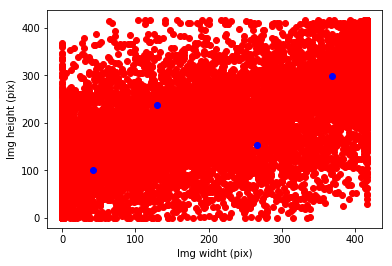

In [4]:
# Visualizing anchor distribution
anchors, X=(anchors_from_data(4))
plt.scatter(X[:,0],X[:,1],c='red')
plt.scatter(anchors[:,0],anchors[:,1],c='blue')
plt.xlabel('Img widht (pix)')
plt.ylabel('Img height (pix)')


In [4]:
x_data, y_data=prep_pics()


 13%|██████████▍                                                                    | 396/2986 [00:30<01:03, 41.02it/s]

In [40]:
model = models.Sequential()
model.add(layers.Conv2D(16, 3, strides=(1, 1), padding='same', kernel_regularizer= l2(5e-4),input_shape=(416, 416, 3)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.1))

filters=[32,64,128,256,512]#,1024]
for fil in filters:
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    model.add(layers.Conv2D(fil, 3, strides=(1, 1), padding='same', kernel_regularizer= l2(5e-4))) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))

model.add(layers.Conv2D(512, 3, strides=(1, 1), padding='same', kernel_regularizer= l2(5e-4)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Conv2D(5, 3, strides=(1, 1), padding='same', activation='linear', kernel_regularizer= l2(5e-4)))  
model.add(layers.Activation('sigmoid'))

model.compile('Adam', loss=custom_loss)#custom_loss)  'mean_squared_error'
#model.summary()

In [41]:
model.fit(x=x_data, y=y_data, batch_size=30, epochs=2, verbose=1, validation_split=0.2, shuffle=True)
model.save('my_model.h5')

#model.load_weights('my_model_weights.h5', by_name=True)
#model.load_weights('my_model_weights.h5', by_name=True)
#del model  # deletes the existing model
#keras.models.load_model('my_model.h5')

Train on 320 samples, validate on 80 samples
Epoch 1/2
320/320 [==============================] - ETA: 3:47 - loss: 33726.058 - ETA: 3:06 - loss: 28243.868 - ETA: 2:38 - loss: 21821.069 - ETA: 2:17 - loss: 16597.062 - ETA: 1:55 - loss: 13411.142 - ETA: 1:34 - loss: 11297.392 - ETA: 1:13 - loss: 9767.018 - ETA: 53s - loss: 8621.3469 - ETA: 33s - loss: 7731.149 - ETA: 13s - loss: 7024.183 - 229s 715ms/step - loss: 6608.3445 - val_loss: 643.5676
Epoch 2/2
320/320 [==============================] - ETA: 3:16 - loss: 535.208 - ETA: 2:55 - loss: 554.576 - ETA: 2:36 - loss: 584.982 - ETA: 2:15 - loss: 602.116 - ETA: 1:54 - loss: 579.755 - ETA: 1:34 - loss: 574.936 - ETA: 1:14 - loss: 563.879 - ETA: 54s - loss: 562.534 - ETA: 33s - loss: 564.54 - ETA: 13s - loss: 559.33 - 222s 693ms/step - loss: 544.0397 - val_loss: 458.3556


In [40]:
#print(y_data[5])

y_true = y_data[5]

In [46]:
y_pred = np.random.rand(*shape)

shape = y_true.shape
no_objects_mask = ma.masked_equal(y_true, 0).mask
no_object_loss = np.sum((0 - sigmoid(y_pred*no_objects_mask)[:,:,0])**2)

bb_loss= np.sum((0 - sigmoid(y_pred * ~no_objects_mask)[:,:,1:])**2)


loss= no_object_scale * no_object_loss +\

print(bb_loss)


[[[0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]]

 [[0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.     

  [0.         0.         0.         0.         0.        ]]]


In [34]:
416/13

32.0

In [8]:
np.save('xdata',x_data)
np.save('ydata',y_data)


In [29]:
x_data=np.load('xdata.npy')
y_data=np.load('ydata.npy')


In [13]:
y_data[1].shape
#print(no_object_scale,no_object_loss,bb_scale,bb_loss)
y=y_data[1]
y[y[:,:,0]==1]
y[i,:,0]==1


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [3]:
loss(y_data[0],y_data[1])

NameError: name 'loss' is not defined

In [5]:
get_custom_objects()

NameError: name 'get_custom_objects' is not defined